In [1]:
# Programa que realiza Pronostico de PM10 mediante Random Forest

# ********** Seccion para Google Colab **************
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/pronostico')
!ls

Mounted at /content/drive
dato_ca_2022_2024_2_cf.csv		 dato_ca_2022_2024_2_Predicciones_RF.csv
dato_ca_2022_2024_2.csv			 dato_ca_2022_2024_cf.csv
dato_ca_2022_2024_2_fore.csv		 dato_ca_2022_2024.csv
dato_ca_2022_2024_2_InterpolaLineal.csv  dato_ca_2022_2024_InterpolaLineal.csv
dato_ca_2022_2024_2_ok.csv		 pronostico.ipynb


In [2]:
# ***** 1.- Leer el archivo de datos y Obtener el rango de fechas completo******************************************
#   1.1- Leer el archivo de datos
import pandas as pd
#path=os.getcwd()+'/'

lv_extension='.csv'
lv_nom_file='dato_ca_2022_2024_2'

lv_nom_file_origen = lv_nom_file + lv_extension
lv_nom_file_cf = lv_nom_file + '_cf' + lv_extension

#df = pd.read_csv(lv_nom_file_origen, sep=';', dayfirst=True, index_col=0, parse_dates=['PERIODO'])
#df = pd.read_csv(lv_nom_file_origen, sep=';', dayfirst=True, parse_dates=['PERIODO'])
df = pd.read_csv(lv_nom_file_origen, delimiter=';', parse_dates=['PERIODO'])

#df['PERIODO'] = pd.to_datetime(df['PERIODO'], format = '%Y-%m-%d %H:%M:%S')
df['PERIODO'] = pd.to_datetime(df['PERIODO'], format='%Y-%m-%d %H')

# Establecer la columna PERIODO como el índice
df.set_index('PERIODO', inplace=True) # = index_col=0
#print('df:',df.head(13));print('df.columns:',df.columns);print('df.dtypes:',df.dtypes)

#   1.2- Obtener el rango de fechas completo
inicio = df.index.min()
fin = df.index.max()
date_range = pd.date_range(start=inicio, end=fin, freq='1H')

# Reindexar el DataFrame original con el rango de fechas completo
df = df.reindex(date_range)

# Crear la columna 'flag_dato' que indica True si es un dato faltante y False si no lo es
#df['flag_dato'] = df.isna().any(axis=1)

# Resetear el índice para hacer que PERIODO sea una columna nuevamente
df.reset_index(inplace=True)

# Renombrar la columna index por PERIODO
df = df.rename(columns={'index': 'PERIODO'})

# Guarda el DataFrame reindexado en un nuevo archivo CSV con cabecera
# df.to_csv(lv_nom_file_cf, sep=';', header=True)

df_copy.dtypes: PM10    float64
dtype: object
tipo de df_copy: datetime64[ns]
forecast.dtypes: Prediccion    float64
dtype: object
tipo de forecast: datetime64[ns]


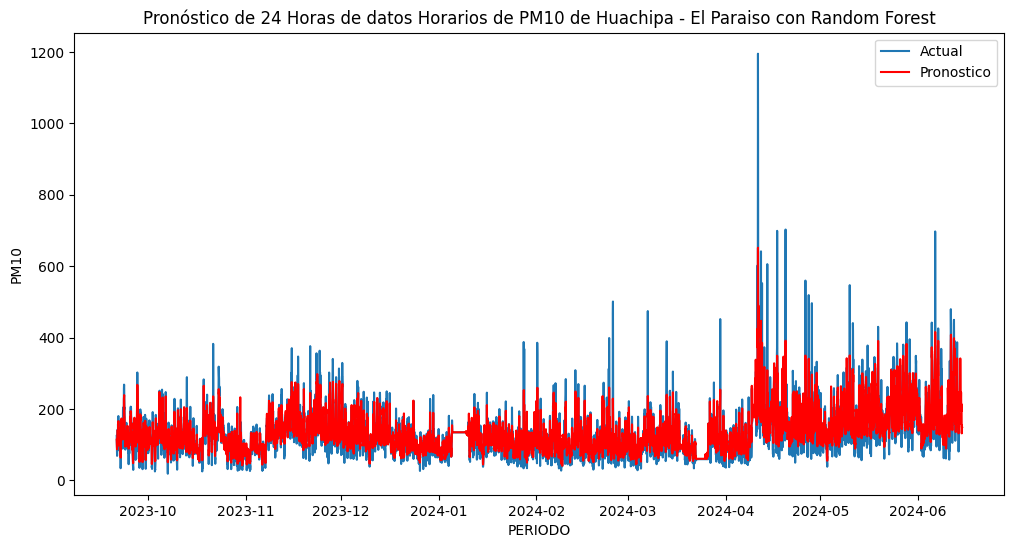

In [3]:
# ********* 2.- Imputacion con Interpolacion Lineal con restriccion de 5 datos consecutivos ******************
#import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 2.1.- Cargar Datos
lv_nom_file_imputacion = lv_nom_file + '_InterpolaLineal'
lv_nom_file_imputacion_destino = lv_nom_file_imputacion + lv_extension

#df = pd.read_csv(lv_nom_file_origen, sep=';', dayfirst=True, parse_dates=['PERIODO'])

# Crear una copia del DataFrame original
df_copy = df.copy(deep=True)
# Establecer la columna PERIODO como el índice
df_copy.set_index('PERIODO', inplace=True)

# 2.2.- Imputar hasta 5 valores faltantes por el metodo de Interpolacion Lineal
df_copy = df_copy.interpolate(method='linear', limit=5, limit_direction='forward', axis=0)

# Guarda el DataFrame reindexado en un nuevo archivo CSV con cabecera
#df_copy.to_csv(lv_nom_file_imputacion_destino, sep=';', header=True)

# *********** 3.-  Pronostico de datos horarios mediante Random Forest ****************
# pip install numpy pandas scikit-learn matplotlib
# 3.1.- Preparar los datos

#import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Configuraciones de columnas y archivo
tx_campo_periodo = 'PERIODO'
tx_campo = 'PM10'  # "SO2"

# Cargar datos de la serie temporal
#data = pd.read_csv('DATOF_PM10_Imputado_Interpolacion.csv', sep=';', parse_dates=[tx_campo_periodo], index_col=tx_campo_periodo)

# Asegurarse de que los datos estén en el formato correcto
df_copy = df_copy.asfreq('H')
#df_copy = df_copy.fillna(method='ffill')  # Rellenar los valores faltantes si es necesario
df_copy = df_copy.ffill()  # Rellenar los valores faltantes con forward fill

# Función para crear un conjunto de datos para la predicción multi-step recursiva
def create_lagged_features(series, n_lags):
    df_tmp = pd.DataFrame(series)
    for lag in range(1, n_lags + 1):
        df_tmp[f'lag_{lag}'] = df_tmp[tx_campo].shift(lag)
    df_tmp.dropna(inplace=True)
    return df_tmp

# Crear características con retardos
n_lags = 24  # Número de retardos (horas anteriores a considerar)
df_lagged = create_lagged_features(df_copy[tx_campo], n_lags)

# Dividir en características (X) y el objetivo (y)
x, y = df_lagged.drop(tx_campo, axis=1), df_lagged[tx_campo]

# 3.2.- Entrenar el modelo Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x, y)

# 3.3.- Realizar predicciones multi-step recursivas desde el inicio de la serie
def predict_recursive_from_start(model, df_copy, n_lags, steps):
  predictions = []
  current_input = df_copy.iloc[:n_lags][tx_campo].values  # Inicial input con los primeros n_lags valores reales
  current_input = current_input[-n_lags:]  # Asegurarse de que el tamaño de la entrada es correcto

  # Realizar la predicción con columnas etiquetadas correctamente
  for i in range(n_lags, len(df_copy)):
    current_input_df = pd.DataFrame([current_input], columns=x.columns)  # Asegurar nombres correctos
    pred = model.predict(current_input_df)[0]
    predictions.append(pred)
    current_input = np.append(current_input[1:], df_copy.iloc[i][tx_campo])

  # Predicción futura
  for _ in range(steps):
    current_input_df = pd.DataFrame([current_input], columns=x.columns)
    pred = model.predict(current_input_df)[0]
    predictions.append(pred)
    current_input = np.append(current_input[1:], pred)

  return predictions
# **************************************************************
# Predecir desde el inicio hasta las próximas 24 horas
predictions = predict_recursive_from_start(model, df_copy, n_lags, 24)

# Crear un DataFrame con las predicciones
#training_predictions = predictions[:len(data) - n_lags]
training_predictions = predictions[:len(df_copy)]
future_predictions = predictions[len(df_copy) - n_lags:]

all_dates = df_copy.index.tolist() + pd.date_range(start=df_copy.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H').tolist()

# Verificar las longitudes de las predicciones y las fechas
#len_predictions = len(training_predictions + future_predictions)
#len_dates = len(all_dates)

# Combinar las fechas de entrenamiento y las futuras
forecast = pd.DataFrame(training_predictions + future_predictions, index=all_dates, columns=['Prediccion'])
# Dar un nombre al campo índice
forecast.index.name = 'PERIODO'

# Verificar tipos de datos
print('df_copy.dtypes:',df_copy.dtypes)
print('tipo de df_copy:',df_copy.index.dtype) #es de tipo datatime

print('forecast.dtypes:',forecast.dtypes)
print('tipo de forecast:',forecast.index.dtype)

# Unir los DataFrames prevaleciendo el índice de la derecha
#data_forecast = df_copy.merge(forecast, left_index=True, right_on='PERIODO', how='right')
#right_index=True en lugar de right_on='PERIODO'
data_forecast = df_copy.merge(forecast, left_index=True, right_index=True, how='right')

# Guardar el DataFrame con las predicciones en un nuevo archivo CSV
lv_nom_file_predicciones= lv_nom_file + '_Predicciones_RF.csv'
data_forecast.to_csv(lv_nom_file_predicciones, sep=';', header=True, index=True)

# Graficar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(df_copy.index, df_copy[tx_campo], label='Actual')
plt.plot(forecast.index, forecast['Prediccion'], label='Pronostico', color='red')
plt.legend()
plt.xlabel(tx_campo_periodo)
plt.ylabel(tx_campo)
plt.title('Pronóstico de 24 Horas de datos Horarios de PM10 de Huachipa - El Paraiso con Random Forest')
plt.show()
